# Titanic classification problem (https://www.kaggle.com/c/titanic)
**The aim is to predict who, among the crew and passengers of the famous Titanic, survived the shipwreck, based on a series of predictors including age, ticket class, number of people in the family, sex, etc.
In this code, I will select and engineer the features to be used and I will test the accuracy of four algorithms: logistic regression, neural networks, random forests and extreme gradient boosting **

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

**Input parameters:**

In [45]:
num_train = 700 # number of training samples
num_cv = 191    # number of samples for cross-validation
num_test = 418  # number of test samples

num_runs = 10   # number of runs for cross-validation

train_file = "train.csv"
test_file = "test.csv"
output_file = "prediction.csv"

**Load data:**

In [46]:
x = pd.read_csv(train_file, sep=',', index_col = 'PassengerId')  # train data
te = pd.read_csv(test_file, sep=',', index_col = 'PassengerId')  # test data

Id = te.index.values

**Print first 5 lines of dataframe with training data:**

In [47]:
print(x.head())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S

**Print first 5 lines of dataframe with test data (note absence of column "Survived" as this is what needs to be predicted in this competition):**

In [48]:
print(te.head())

             Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

              Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
PassengerId                                                       
892          34.5      0      0   330911   7.8292   NaN        Q  
893          47.0      1      0   363272   7.0000   NaN        S  
894          62.0      0      0   240276   9.6875   NaN        Q  
895          27.0      0      0   315154   8.6625   NaN        S  
896          22.0      1      1  3101298  12.2875   NaN   

## Feature selection and engineering

**Drop 'Ticket' column as not useful for prediction:**

In [49]:
x.drop('Ticket', axis=1, inplace=True) # drop 'Ticket' column as not useful for prediction
te.drop('Ticket', axis=1, inplace=True)

**Assign number to categorical variable 'Sex':**

In [50]:
x['Sex'] = x['Sex'].astype('category')
x['Sex'] = x['Sex'].cat.codes
te['Sex'] = te['Sex'].astype('category')
te['Sex'] = te['Sex'].cat.codes

**Process 'Age' column:**

In [51]:
# Replace missing ages with -5 as it makes no sense to assign to mean age value
x.loc[pd.isnull(x['Age']), 'Age'] = -5
te.loc[pd.isnull(te['Age']), 'Age'] = -5

# Set to 65 all ages above 65 (as very limited counts above 65)
x.loc[x['Age']>65, 'Age'] = 65
te.loc[te['Age']>65, 'Age'] = 65

# Place ages in age groups (to decrease noise)
labels = [ "{0} - {1}".format("%02d" % i, "%02d" % (i + 4)) for i in range(-5, 70, 5) ]

x['Age group'] = pd.cut(x['Age'], range(-5, 75, 5), right=False, labels=labels)
te['Age group'] = pd.cut(te['Age'], range(-5, 75, 5), right=False, labels=labels)

x.drop('Age', axis=1, inplace=True)
te.drop('Age', axis=1, inplace=True)

# Convert categorical values to numerical (dummy variable)
x['Age group'] = x['Age group'].cat.codes
te['Age group'] = te['Age group'].cat.codes

**Process columns 'SibSp' (number of siblings/spouses aboard the Titanic) and 'Parch' (number of parents/children aboard the Titanic):**

In [52]:
# Replace SibSp and Parch with their sum to find number of members in family, which is a better predictor
x['Family'] = x['SibSp'] + x['Parch']
te['Family'] = te['SibSp'] + te['Parch']

x.loc[x['Family']>4, 'Family'] = 4 # put together all large families (because there are only few of them)
te.loc[te['Family']>4, 'Family'] = 4

x.drop('SibSp', axis=1, inplace=True)
x.drop('Parch', axis=1, inplace=True)
te.drop('SibSp', axis=1, inplace=True)
te.drop('Parch', axis=1, inplace=True)

**Process columns 'Fare' and 'Embarked':**

In [53]:
# Replace one missing value for 'Fare' in test set with average among train set
te.loc[pd.isnull(te['Fare']), 'Fare'] = x['Fare'].mean()

# One-hot encoding for categorical variable 'Embarked'
x = pd.get_dummies( x, columns=['Embarked'], drop_first=True )
te = pd.get_dummies( te, columns=['Embarked'], drop_first=True )

**Process column 'Name' to extract the title and use it as a predictor for survival (Mr, Mrs, Miss, etc.):**

In [54]:
# Extract title from 'Name'
x.loc[x['Name'].str.contains('Mr. '), 'Name'] = 'Mr'
x.loc[x['Name'].str.contains('Mrs. '), 'Name'] = 'Mrs'
x.loc[x['Name'].str.contains('Miss. '), 'Name'] = 'Miss'
x.loc[x['Name'].str.contains('Master. '), 'Name'] = 'Master'
x['Name'] = ['Other' if ((k != 'Mr') & (k != 'Mrs') & (k != 'Miss') & (k != 'Master')) else k for k in x['Name']]

te.loc[te['Name'].str.contains('Mr. '), 'Name'] = 'Mr'
te.loc[te['Name'].str.contains('Mrs. '), 'Name'] = 'Mrs'
te.loc[te['Name'].str.contains('Miss. '), 'Name'] = 'Miss'
te.loc[te['Name'].str.contains('Master. '), 'Name'] = 'Master'
te['Name'] = ['Other' if ((k != 'Mr') & (k != 'Mrs') & (k != 'Miss') & (k != 'Master')) else k for k in te['Name']]

# One-hot encoding of title
x = pd.get_dummies( x, columns=['Name'], drop_first=True )
te = pd.get_dummies( te, columns=['Name'], drop_first=True )

**Process column 'Cabin':**

In [55]:
# Substitute missing values for 'Cabin' with 'other'
x.loc[pd.isnull(x['Cabin']), 'Cabin'] = 'other'
te.loc[pd.isnull(te['Cabin']), 'Cabin'] = 'other'

# Extract cabin letter from 'Cabin'
x.loc[x['Cabin'].str.contains('A'), 'Cabin'] = 'A'
x.loc[x['Cabin'].str.contains('B'), 'Cabin'] = 'B'
x.loc[x['Cabin'].str.contains('C'), 'Cabin'] = 'C'
x.loc[x['Cabin'].str.contains('D'), 'Cabin'] = 'D'
x.loc[x['Cabin'].str.contains('E'), 'Cabin'] = 'E'
x.loc[x['Cabin'].str.contains('F'), 'Cabin'] = 'F'
x.loc[x['Cabin'].str.contains('G'), 'Cabin'] = 'F' # because very few counts in category G
x['Cabin'] = ['Other' if ((k != 'A') & (k != 'B') & (k != 'C') & (k != 'D') & (k != 'E') & (k != 'F') & (k != 'G')) else k for k in x['Cabin']]

te.loc[te['Cabin'].str.contains('A'), 'Cabin'] = 'A'
te.loc[te['Cabin'].str.contains('B'), 'Cabin'] = 'B'
te.loc[te['Cabin'].str.contains('C'), 'Cabin'] = 'C'
te.loc[te['Cabin'].str.contains('D'), 'Cabin'] = 'D'
te.loc[te['Cabin'].str.contains('E'), 'Cabin'] = 'E'
te.loc[te['Cabin'].str.contains('F'), 'Cabin'] = 'F'
te.loc[te['Cabin'].str.contains('G'), 'Cabin'] = 'F' # because very few counts in category G
te['Cabin'] = ['Other' if ((k != 'A') & (k != 'B') & (k != 'C') & (k != 'D') & (k != 'E') & (k != 'F') & (k != 'G')) else k for k in te['Cabin']]

# One-hot encoding of cabin letter
x = pd.get_dummies( x, columns=['Cabin'], drop_first=True )
te = pd.get_dummies( te, columns=['Cabin'], drop_first=True )

**Save 'Survived' column in new variable y**

In [56]:
y = x['Survived']
x.drop('Survived', axis=1, inplace=True) # drop column 'Survived' from dataframe of predictors x

**Convert x, te and y dataframes to numpy arrays**

In [57]:
x = np.array(x)
te = np.array(te)
y = np.array(y)
y = np.expand_dims(y, axis=1)

## Prediction using various machine learning methods

**Initialize prediction accuracy for train set and cross-validation set**

In [58]:
train_accuracy_log = np.zeros(num_runs)
cv_accuracy_log = np.zeros(num_runs)

train_accuracy_neur = np.zeros(num_runs)
cv_accuracy_neur = np.zeros(num_runs)

train_accuracy_randfor = np.zeros(num_runs)
cv_accuracy_randfor = np.zeros(num_runs)

train_accuracy_xgboost = np.zeros(num_runs)
cv_accuracy_xgboost = np.zeros(num_runs)

**Prediction using logistic regression (using only linear features), neural networks, random forests and extreme gradient boosting. The train set is sampled randomly in order to create train and cross-validation sets. The first is used for training, the second for evaluating accuracy on unseen examples. This procedure is repeated 10 times, and the accuracies for every run are recorded.**

In [59]:
for kk in range(num_runs):    
        
    ## select randomly training and cross validation datasets
    x_tr, x_cv, y_tr, y_cv = train_test_split(x, y, test_size=num_cv/(num_train+num_cv), random_state=None)
     
    # normalize independent variables to mean = 0 and std = 1    
    xtrNorm = np.zeros(x_tr.shape)
    for k in range(x_tr.shape[1]):
        xtrNorm[:,k] = (x_tr[:,k] - np.mean(x_tr[:,k])) / np.std(x_tr[:,k])
    
    xcvNorm = np.zeros(x_cv.shape)
    for k in range(x_cv.shape[1]): 
        xcvNorm[:,k] = (x_cv[:,k] - np.mean(x_tr[:,k])) / np.std(x_tr[:,k])
    
    teNorm = np.zeros(te.shape)
    for k in range(te.shape[1]):
        teNorm[:,k] = (te[:,k] - np.mean(x_tr[:,k])) / np.std(x_tr[:,k])
    
    # Add intercept term to training, cross-validation and test data
    x_tr = np.concatenate((np.ones((num_train,1)), xtrNorm), axis=1)
    x_cv = np.concatenate((np.ones((num_cv,1)), xcvNorm), axis=1)
    teNorm = np.concatenate((np.ones((num_test,1)), teNorm), axis=1)
            
    y_tr = np.squeeze(y_tr)
    y_cv = np.squeeze(y_cv) 
    
    
    ##########################################
    ## Logistic regression using only linear features
    ##########################################
    
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1,
                             fit_intercept=False, intercept_scaling=1, class_weight=None,
                             random_state=None, solver='liblinear', max_iter=100,
                             multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
    clf.fit(x_tr, y_tr)
    
    pred_tr = clf.predict(x_tr)
    pred_cv = clf.predict(x_cv)
    
    # Compute accuracy on training set
    train_accuracy_log[kk] = np.mean(pred_tr == y_tr) * 100
    
    # Compute accuracy on cross-validation set
    cv_accuracy_log[kk] = np.mean(pred_cv == y_cv) * 100
    
    
    ##########################################
    ## Neural network
    ##########################################
    
    # hyper parameters have been optimized using grid-search method
    clf = MLPClassifier(solver='lbfgs', alpha=14, hidden_layer_sizes=(12, 12), random_state=1)
   
    clf.fit(x_tr, y_tr)
    
    pred_tr = clf.predict(x_tr)
    pred_cv = clf.predict(x_cv)
    
    # Compute accuracy on training set
    train_accuracy_neur[kk] = np.mean(pred_tr == y_tr) * 100
    
    # Compute accuracy on cross-validation set
    cv_accuracy_neur[kk] = np.mean(pred_cv == y_cv) * 100 


    ##########################################
    ## Random forest
    ##########################################
    
    clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=4,
                           min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None,
                           verbose=0, warm_start=False, class_weight=None)
    clf.fit(x_tr, y_tr)
    
    pred_tr = clf.predict(x_tr)
    pred_cv = clf.predict(x_cv)
    
    # Compute accuracy on training set
    train_accuracy_randfor[kk] = np.mean(pred_tr == y_tr) * 100
    
    # Compute accuracy on cross-validation set
    cv_accuracy_randfor[kk] = np.mean(pred_cv == y_cv) * 100 
    
    
    ##########################################
    ## xgboost
    ##########################################
    
    #clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
    clf = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.015, gamma=0.5)
    clf.fit(x_tr, y_tr)
    
    pred_tr = clf.predict(x_tr)
    pred_cv = clf.predict(x_cv)
    
    # Compute accuracy on training set
    train_accuracy_xgboost[kk] = np.mean(pred_tr == y_tr) * 100
    
    # Compute accuracy on cross-validation set
    cv_accuracy_xgboost[kk] = np.mean(pred_cv == y_cv) * 100 
      

**Print results of calculation:**

In [60]:
# display mean accuracies and their standard deviations for logistic regression
print("\nAverage train accuracy for logistic regression: %f" % np.mean(train_accuracy_log))
print("with standard deviation of the mean: %f\n" % (np.std(train_accuracy_log) / np.sqrt(num_runs)))
print("Average cross validation accuracy for logistic regression: %f" % np.mean(cv_accuracy_log))
print("with standard deviation of the mean: %f\n" % (np.std(cv_accuracy_log) / np.sqrt(num_runs)))

# display mean accuracies and their standard deviations for neural network
print("\nAverage train accuracy for neural network: %f" % np.mean(train_accuracy_neur))
print("with standard deviation of the mean: %f\n" % (np.std(train_accuracy_neur) / np.sqrt(num_runs)))
print("Average cross validation accuracy for neural network: %f" % np.mean(cv_accuracy_neur))
print("with standard deviation of the mean: %f\n" % (np.std(cv_accuracy_neur) / np.sqrt(num_runs)))

# display mean accuracies and their standard deviations for random forests
print("\nAverage train accuracy for random forests: %f" % np.mean(train_accuracy_randfor))
print("with standard deviation of the mean: %f\n" % (np.std(train_accuracy_randfor) / np.sqrt(num_runs)))
print("Average cross validation accuracy for random forests: %f" % np.mean(cv_accuracy_randfor))
print("with standard deviation of the mean: %f\n" % (np.std(cv_accuracy_randfor) / np.sqrt(num_runs)))

# display mean accuracies and their standard deviations for extreme gradient boosting
print("\nAverage train accuracy for xgb: %f" % np.mean(train_accuracy_xgboost))
print("with standard deviation of the mean: %f\n" % (np.std(train_accuracy_xgboost) / np.sqrt(num_runs)))
print("Average cross validation accuracy for xgb: %f" % np.mean(cv_accuracy_xgboost))
print("with standard deviation of the mean: %f\n" % (np.std(cv_accuracy_xgboost) / np.sqrt(num_runs))) 


Average train accuracy for logistic regression: 82.942857
with standard deviation of the mean: 0.247601

Average cross validation accuracy for logistic regression: 82.303665
with standard deviation of the mean: 0.538020


Average train accuracy for neural network: 84.228571
with standard deviation of the mean: 0.272704

Average cross validation accuracy for neural network: 83.455497
with standard deviation of the mean: 0.602436


Average train accuracy for random forests: 87.685714
with standard deviation of the mean: 0.293327

Average cross validation accuracy for random forests: 83.507853
with standard deviation of the mean: 0.770363


Average train accuracy for xgb: 86.142857
with standard deviation of the mean: 0.249080

Average cross validation accuracy for xgb: 84.397906
with standard deviation of the mean: 0.661429



**The best performance (84% average accuracy for cross-validation set) is obtained with the extreme gradient boosting algorithm, although the difference compared to other methods is not statistically significant.**

## Grid search for hyper parameters tuning

**Optimal hyper parameters for the above methods have been determined using grid search. As an example, a plot of the accuracy as a function of regularization parameter alpha and number of nodes in internal layers for neural network is shown below. Accuracies for both training set and cross-validation set are reported. As can be seen, accuracy for training set increases with small alpha and large neural network size. However, this leads to overfitting, decreasing accuracy for unseen examples. Values of alpha=14 and nodes=12 have been chosen, as they lie within the area showing higher accuracy for cross-validation set.
The plots have been obtained averaging 100 runs with random splitting of training and cross-validation sets in order to decrease noise in results. However, some noise is still present due to the small differences between accuracy values.**

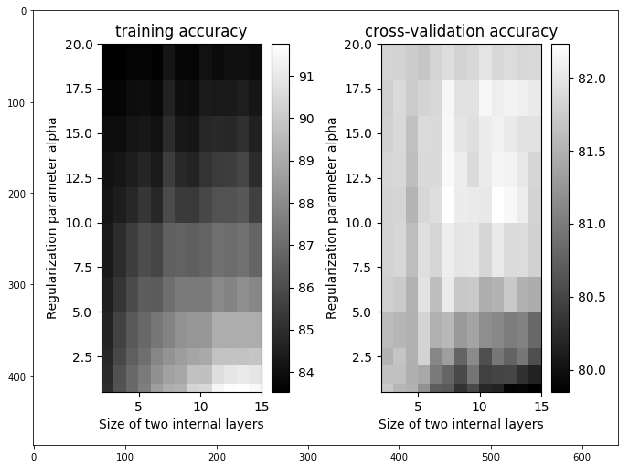

In [61]:
plt.figure(figsize=(18, 8))
accImg = plt.imread('acc_neur_network.png')
plt.imshow(accImg)
plt.show()